# Data Visualization single event


In [1]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import awkward as ak

In [2]:
uproot.__version__

'5.0.9'

In [3]:
!ls ..

CaloGNN.png
GNNKeras.ipynb
LLP_for_Calo.ipynb
LLP_time-Copy1.ipynb
LLP_time.ipynb
LLP_time_1.ipynb
MLBasedCaloClustering
MLBasedCaloClusteringPipeLine
ML_01.ipynb
ML_Cell_data
ML_for_Calo.ipynb
ML_for_Calo_students.ipynb
MyxAODAnalysis_100evnts.outputs.root
MyxAODAnalysis_100evnts_old.outputs.root
Untitled.ipynb
ZacClub.ipynb
debottam@237.93.105.92
fixed_length.py
input.txt
karate.edgelist
mlp-0000.params
mlp-symbol.json
mxHybrid.ipynb
mxnet_exported_mlp.onnx
my_env
saved_model
trackML.ipynb


In [4]:
file = uproot.open("../MyxAODAnalysis_100evnts.outputs.root")

In [5]:
file.keys()

['analysis;1']

In [6]:
tree = file['analysis']

In [7]:
tree.keys() # no. of variables per event

['RunNumber',
 'EventNumber',
 'cell_eta',
 'cell_phi',
 'cell_x',
 'cell_y',
 'cell_z',
 'cell_subCalo',
 'cell_sampling',
 'cell_size',
 'cell_e',
 'cell_noiseSigma',
 'cell_SNR',
 'cell_time',
 'cell_weight',
 'cell_truth',
 'cell_truth_indices',
 'cell_shared_indices',
 'cell_cluster_index',
 'cluster_to_cell_indices',
 'cluster_to_cell_weights',
 'cell_to_cluster_e',
 'cell_to_cluster_eta',
 'cell_to_cluster_phi',
 'cluster_eta',
 'cluster_phi',
 'cluster_e',
 'cellsNo_cluster',
 'clustersNo_event',
 'jet_energyWtdTimeAve']

In [8]:
branches = tree.arrays()

In [9]:
# this one just dealing with 1 event (e.g. 0th event)
cell_coordinate_x = branches['cell_x'][0]
cell_coordinate_y = branches['cell_y'][0]
cell_coordinate_z = branches['cell_z'][0]
cell_subCalo = branches['cell_subCalo'][0]
cell_sampling = branches['cell_sampling'][0]
cell_weight = branches['cell_weight'][0]
cell_truth = branches['cell_truth'][0]
cell_to_cluster_e = branches['cell_to_cluster_e'][0]
cell_noiseSigma = branches['cell_noiseSigma'][0]
cell_SNR = branches['cell_SNR'][0]
cell_time = branches['cell_time'][0]
cellsNo_cluster = branches['cellsNo_cluster'][0]
clustersNo_event = branches['clustersNo_event'][0]
cell_cluster_index = branches['cell_cluster_index'][0]
cell_e = branches['cell_e'][0]
cluster_to_cell_indices = branches['cluster_to_cell_indices'][0]
cell_truth_indices = branches['cell_truth_indices'][0]
cell_shared_indices = branches['cell_shared_indices'][0]

In [10]:
# convert them to numpy array otherwise they I believe behave like lists
cell_coordinate_x = np.array(cell_coordinate_x)
cell_coordinate_y = np.array(cell_coordinate_y)
cell_coordinate_z = np.array(cell_coordinate_z)
cell_subCalo = np.array(cell_subCalo)
cell_sampling = np.array(cell_sampling)
cell_weight = np.array(cell_weight)
cell_truth = np.array(cell_truth)
cell_to_cluster_e = np.array(cell_to_cluster_e)
cell_SNR = np.array(cell_SNR)
cell_noiseSigma = np.array(cell_noiseSigma)
cell_time = np.array(cell_time)
cellsNo_cluster = np.array(cellsNo_cluster)
clustersNo_event = np.array(clustersNo_event)
cell_to_cluster_index = np.array(cell_cluster_index)
cell_e = np.array(cell_e)
#cluster_to_cell_indices = np.array(cluster_to_cell_indices)

In [11]:
## No. of cell per event
cellsInCalorimeter = len(cell_e)
print("no. of cells in Calorimeter: ", cellsInCalorimeter)

no. of cells in Calorimeter:  187652


# Description of data set:
We decided to use following features from an event
### Geometric features:

##### 1. cell_coordinate_x (mm)
##### 2. cell_coordinate_y (mm)
##### 3. cell_coordinate_z (mm)
##### 4. cell_subCalo          : LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
##### 5. cell_sampling         : More granular information of the subcalo above

### Deposited energy related features:

##### 6. cell_SNR          : signal to noise ratio of a cell
##### 7. cell_e               : Energy deposited in a cell in MeV

### Topocluster related cell features:

##### 8. cell_truth             : 0/1 whether cell takes part in a cluster or not
##### 9. cell_weight            : could have more than 1 entry (value 0 to 1) but using the max weight for simplicity
##### 10. cell_to_cluster_index  : index/id of the cluster where the cell has maximum weight (again for initial study)
##### 11. cell_to_cluster_e      : energy of the cluster where the cell has maximum weight (again for initial study)

# Visualization of cell geometry

### A. Y-Z coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

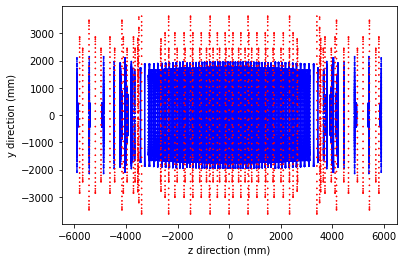

In [12]:
s = 1
col = np.where(cell_subCalo==3,'r','b')
plt.scatter(cell_coordinate_z, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("z direction (mm)")
plt.ylabel("y direction (mm)")

### B. X-Y coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

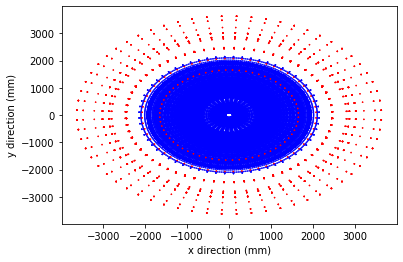

In [13]:
plt.scatter(cell_coordinate_x, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("x direction (mm)")
plt.ylabel("y direction (mm)")

## Visualization of the features 

xbin_count:  113


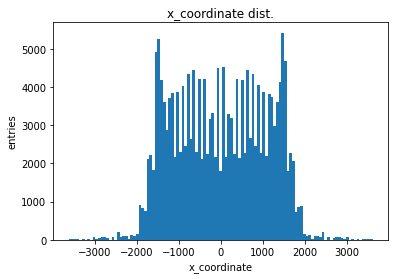

In [14]:
q1, q3 = np.percentile(cell_coordinate_x, 25), np.percentile(cell_coordinate_x, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_coordinate_x) ** (1 / 3))
xbin_count = int(np.ceil((cell_coordinate_x.max() - cell_coordinate_x.min()) / bin_width))
print("xbin_count: ",xbin_count)
plt.hist(cell_coordinate_x, bins=xbin_count)
plt.title("x_coordinate dist.")
plt.xlabel("x_coordinate")
plt.ylabel("entries")
plt.show()

ybin_count:  113


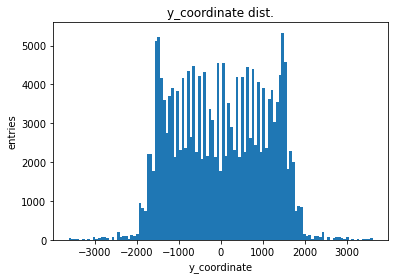

In [15]:
q1, q3 = np.percentile(cell_coordinate_y, 25), np.percentile(cell_coordinate_y, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_coordinate_y) ** (1 / 3))
ybin_count = int(np.ceil((cell_coordinate_y.max() - cell_coordinate_y.min()) / bin_width))
print("ybin_count: ",ybin_count)
plt.hist(cell_coordinate_y, bins=ybin_count)
plt.title("y_coordinate dist.")
plt.xlabel("y_coordinate")
plt.ylabel("entries")
plt.show()

zbin_count:  71


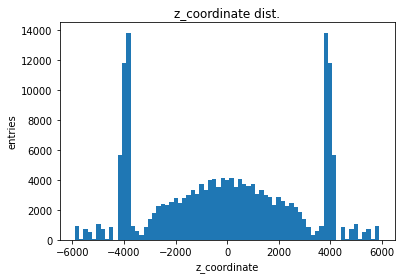

In [16]:
q1, q3 = np.percentile(cell_coordinate_z, 25), np.percentile(cell_coordinate_z, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_coordinate_z) ** (1 / 3))
zbin_count = int(np.ceil((cell_coordinate_z.max() - cell_coordinate_z.min()) / bin_width))
print("zbin_count: ",zbin_count)
plt.hist(cell_coordinate_z, bins=zbin_count)
plt.title("z_coordinate dist.")
plt.xlabel("z_coordinate")
plt.ylabel("entries")
plt.show()

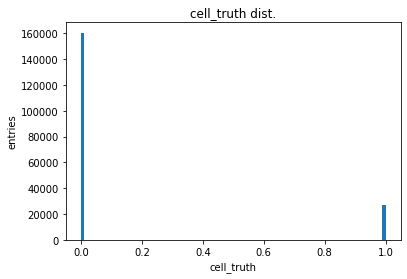

In [17]:
#q1, q3 = np.percentile(cell_truth, 25), np.percentile(cell_truth, 75)
#iqr = q3 - q1
#bin_width = (2 * iqr) / (len(cell_truth) ** (1 / 3))
#truthbin_count = int(np.ceil((cell_truth.max() - cell_truth.min()) / bin_width))
plt.hist(cell_truth, bins=100)
#print("bin count: ",truthbin_count)
plt.title("cell_truth dist.")
plt.xlabel("cell_truth")
plt.ylabel("entries")
plt.show()

In [18]:
participatingCell_Indx = [i for i in range(len(cell_truth)) if cell_truth[i]==1]
nonParticipatingCell_Indx = [i for i in range(len(cell_truth)) if cell_truth[i]==0]

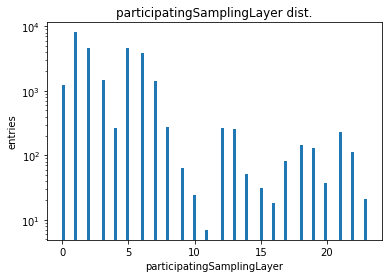

In [19]:
participatingSamplingLayer = cell_sampling[participatingCell_Indx]
plt.hist(participatingSamplingLayer, bins=100)
plt.title("participatingSamplingLayer dist.")
plt.xlabel("participatingSamplingLayer")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

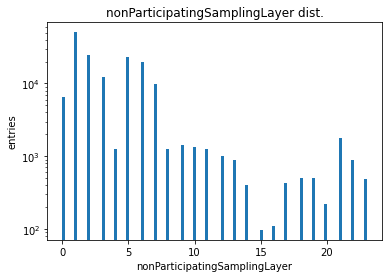

In [20]:
nonParticipatingSamplingLayer = cell_sampling[nonParticipatingCell_Indx]
plt.hist(nonParticipatingSamplingLayer, bins=100)
plt.title("nonParticipatingSamplingLayer dist.")
plt.xlabel("nonParticipatingSamplingLayer")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

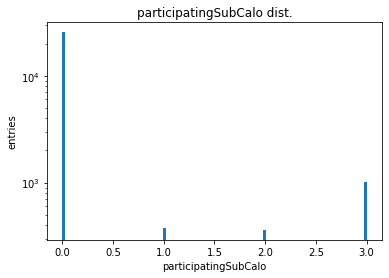

In [21]:
#LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
participatingSubCalo = cell_subCalo[participatingCell_Indx]
plt.hist(participatingSubCalo, bins=100)
plt.title("participatingSubCalo dist.")
plt.xlabel("participatingSubCalo")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

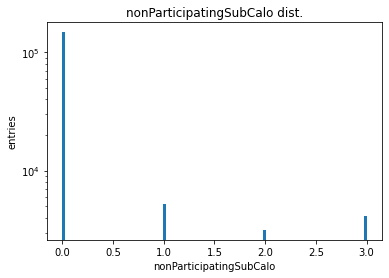

In [22]:
#LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
nonParticipatingSubCalo = cell_subCalo[nonParticipatingCell_Indx]
plt.hist(nonParticipatingSubCalo, bins=100)
plt.title("nonParticipatingSubCalo dist.")
plt.xlabel("nonParticipatingSubCalo")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

bin count:  7390


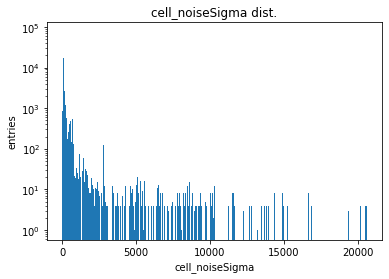

In [23]:
q1, q3 = np.percentile(cell_noiseSigma, 25), np.percentile(cell_noiseSigma, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_noiseSigma) ** (1 / 3))
noisebin_count = int(np.ceil((cell_noiseSigma.max() - cell_noiseSigma.min()) / bin_width))
print("bin count: ", noisebin_count)
plt.hist(cell_noiseSigma, bins=1000)
plt.title("cell_noiseSigma dist.")
plt.xlabel("cell_noiseSigma")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

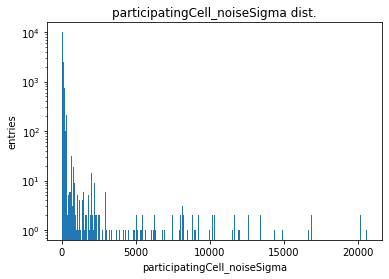

In [24]:
participatingCell_noiseSigma = cell_noiseSigma[participatingCell_Indx]
plt.hist(participatingCell_noiseSigma, bins=1000)
plt.title("participatingCell_noiseSigma dist.")
plt.xlabel("participatingCell_noiseSigma")
plt.yscale("log")
plt.ylabel("entries")
plt.show()


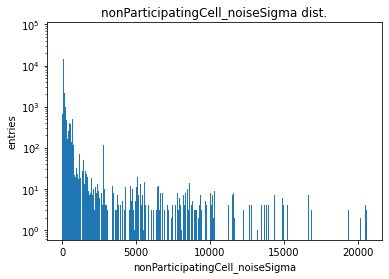

In [25]:
nonParticipatingCell_noiseSigma = cell_noiseSigma[nonParticipatingCell_Indx]
plt.hist(nonParticipatingCell_noiseSigma, bins=1000)
plt.title("nonParticipatingCell_noiseSigma dist.")
plt.xlabel("nonParticipatingCell_noiseSigma")
plt.yscale("log")
plt.ylabel("entries")
plt.show()


bin_count:  37888


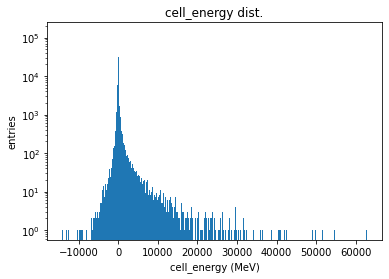

In [26]:
q1, q3 = np.percentile(cell_e, 25), np.percentile(cell_e, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_e) ** (1 / 3))
cellEnergybin_count = int(np.ceil((cell_e.max() - cell_e.min()) / bin_width))
print("bin_count: ",cellEnergybin_count)
plt.hist(cell_e, 500)
plt.title("cell_energy dist.")
plt.xlabel("cell_energy (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

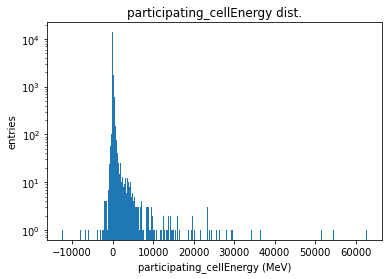

In [27]:
participating_cellEnergy = cell_e[participatingCell_Indx]
plt.hist(participating_cellEnergy, 500)
plt.title("participating_cellEnergy dist.")
plt.xlabel("participating_cellEnergy (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

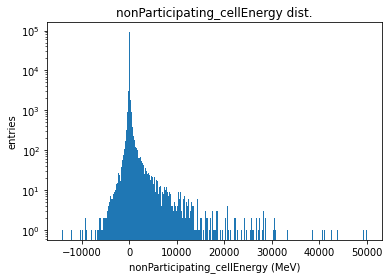

In [28]:
nonParticipating_cellEnergy = cell_e[nonParticipatingCell_Indx]
plt.hist(nonParticipating_cellEnergy, 500)
plt.title("nonParticipating_cellEnergy dist.")
plt.xlabel("nonParticipating_cellEnergy (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

bin_count:  6956


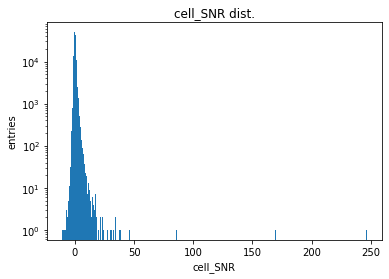

In [29]:
q1, q3 = np.nanpercentile(cell_SNR, 25), np.nanpercentile(cell_SNR, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(cell_SNR) ** (1 / 3))
cellSNRbin_count = int((max(cell_SNR) - min(cell_SNR)) / bin_width)
print("bin_count: ",cellSNRbin_count)
plt.hist(cell_SNR, 500)
plt.title("cell_SNR dist.")
plt.xlabel("cell_SNR")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

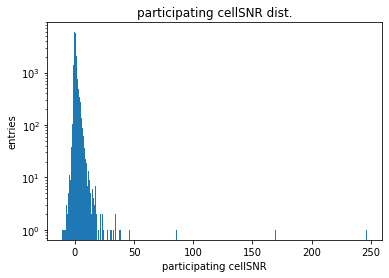

In [30]:
participating_cellSNR = cell_SNR[participatingCell_Indx]
plt.hist(participating_cellSNR, 500)
plt.title("participating cellSNR dist.")
plt.xlabel("participating cellSNR")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

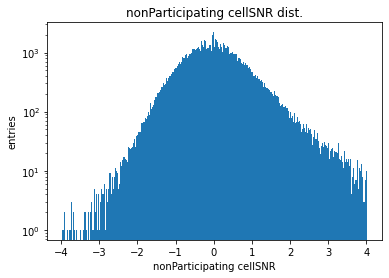

In [31]:
nonParticipating_cellSNR = cell_SNR[nonParticipatingCell_Indx]
plt.hist(nonParticipating_cellSNR, 500)
plt.title("nonParticipating cellSNR dist.")
plt.xlabel("nonParticipating cellSNR")
plt.ylabel("entries")
plt.yscale("log")
plt.show()